# Oil Price Analysis

Import neccessary libraries and modules

In [69]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os, sys
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in scripts/
from data_preprocessor import DataPreprocessor  

logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

**Data Collection**

- Download the brent oil price data

In [70]:
# Set google drive url for loading the dataset
url = 'https://drive.google.com/file/d/1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5/view?usp=drive_link'

# Setup the data preprocessor class
processor = DataPreprocessor(url, logger=logger)
# Load the data
price_data = processor.load_data()

INFO:logger:Directory checked/created: ../data/
INFO:logger:Starting download from Google Drive.
Downloading...
From: https://drive.google.com/uc?export=download&id=1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5
To: /home/noh/10Academy/oil-price-statistical-modeling/data/data.csv
100%|██████████| 156k/156k [00:00<00:00, 274kB/s]
INFO:logger:File downloaded successfully to ../data/data.csv.
INFO:logger:Data loaded into DataFrame successfully.


**Note**: always check `logs/notebooks.log` file for any log messages

In [71]:
# Explore the first 10 rows
price_data.head(10)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


In [72]:
# Explore the last 10 rows
price_data.tail(10)

,Price
Date,
2022-11-01,95.12
2022-11-02,96.07
2022-11-03,95.29
2022-11-04,99.53
2022-11-07,99.87
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37


### Data Cleaning and Preprocessing

Inspect the dataset for completeness and structure

In [73]:
processor.inspect(price_data)

INFO:logger:DataFrame dimensions: (9011, 2)
INFO:logger:Displayed data types for each column.
INFO:logger:No missing values detected.


Dimensions (rows, columns): (9011, 2)

Data Types:
Date     datetime64[ns]
Price           float64
dtype: object

No missing values found.

Unique Values in Each Column:
Date     9011
Price    5015
dtype: int64


INFO:logger:Duplicate rows found: 0


Number of duplicate rows: 0

Summary Statistics for Numeric Columns:


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


**Detect Outliers**

- Box plot

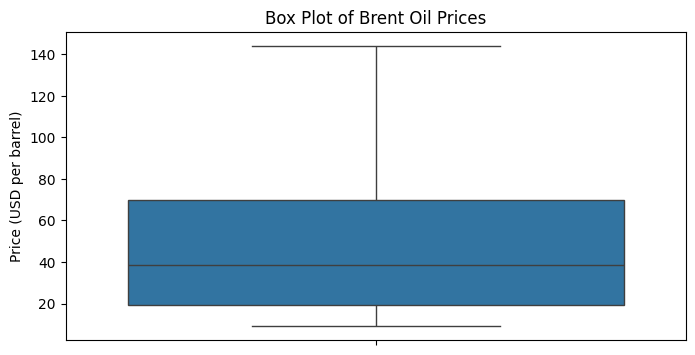

In [74]:
# Assuming 'price_data' is your DataFrame containing the 'Price' column
plt.figure(figsize=(8, 4))
sns.boxplot(data=price_data, y='Price')
plt.title('Box Plot of Brent Oil Prices')
plt.ylabel('Price (USD per barrel)')
plt.show()

- No outliers detected in the price data

### Exploratory Data Analysis

- Descriptive Statistics

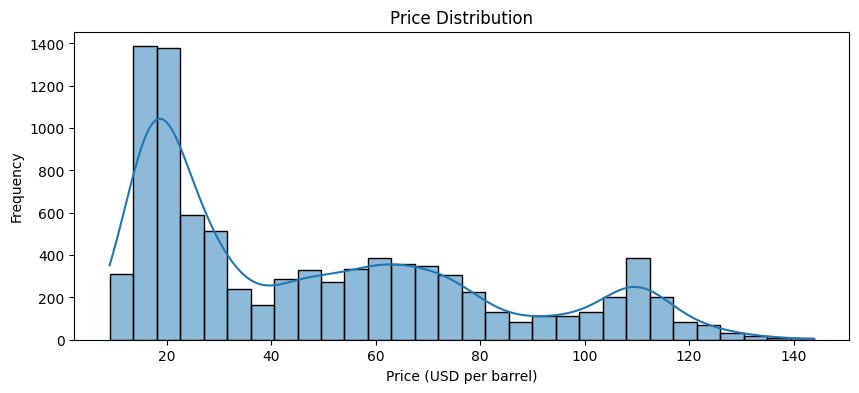

In [75]:
# Visualize the price distribution
plt.figure(figsize=(10, 4))
sns.histplot(price_data['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (USD per barrel)')
plt.ylabel('Frequency')
plt.show()


**Time Series Analysis**
- Overall price trend

    - Create a line graph to visualize price trends over time.

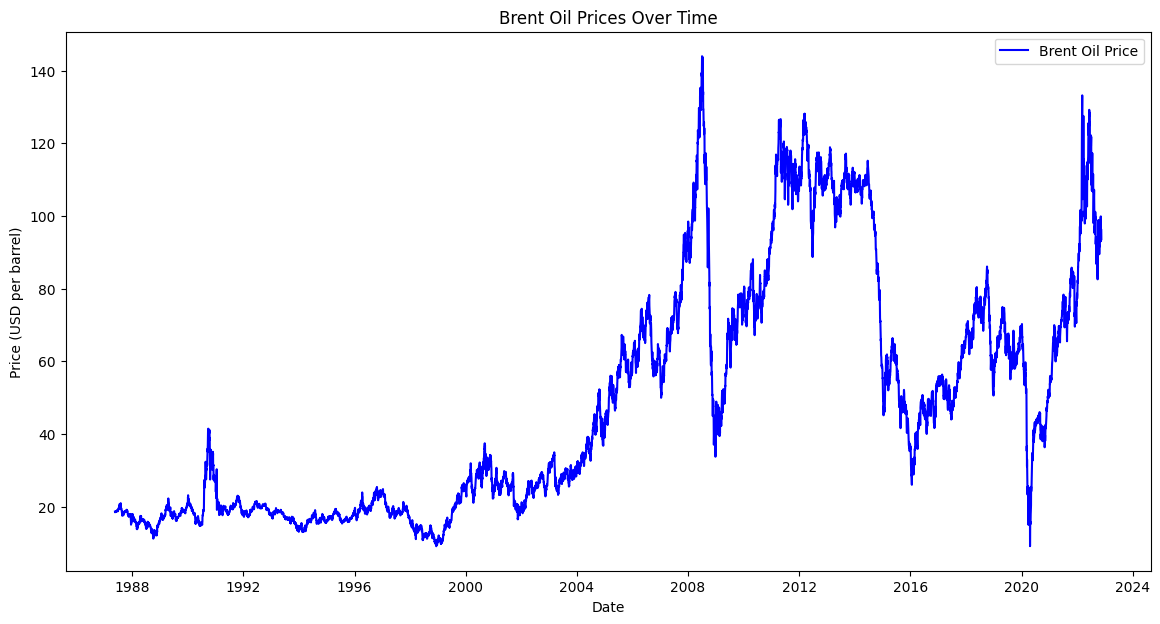

In [76]:
plt.plot(price_data.index, price_data['Price'], label='Brent Oil Price', color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
# plt.axvline(x='Date', color='red', linestyle='--', label='Event Marker')
plt.legend()
plt.show()


- **Seasonality Analysis**
    - Aggregate prices by year and visualize seasonal patterns.

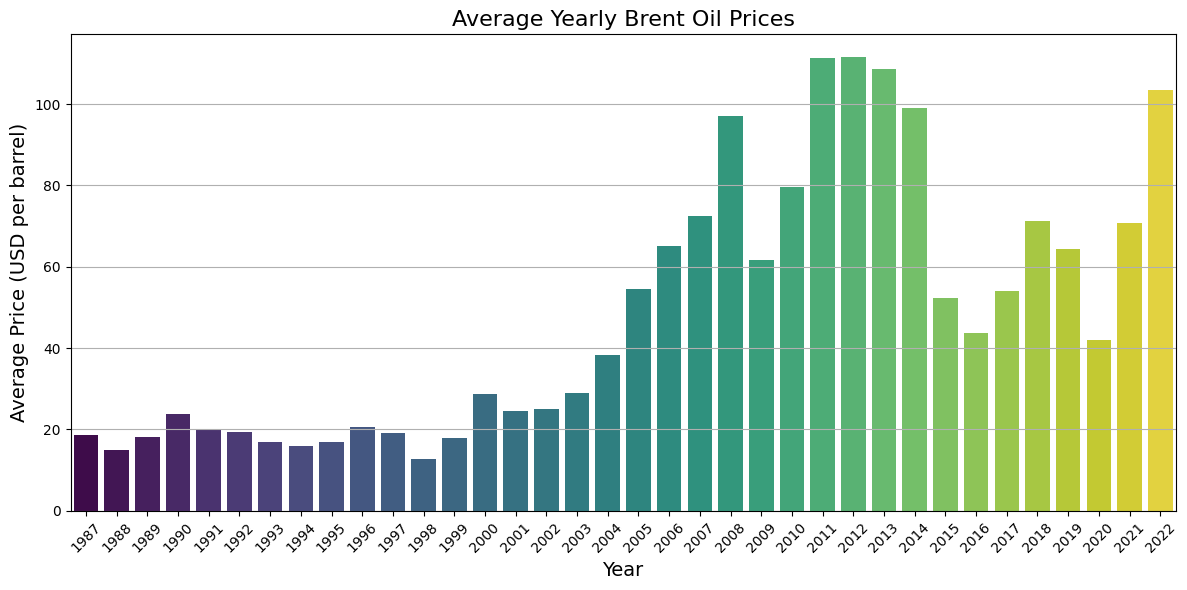

In [77]:
# Extract the year from the Date
df = price_data.copy().reset_index()

df['Year'] = df['Date'].dt.year

# Calculate average price per year
yearly_avg = df.groupby('Year')['Price'].mean().reset_index()

# Plot yearly average prices
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Price', data=yearly_avg, hue='Year', legend=False, palette='viridis')
plt.title('Average Yearly Brent Oil Prices', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (USD per barrel)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- **Rolling Volatility Analysis**

    - Rolling standard deviation (e.g., 30-day) line plot of prices.

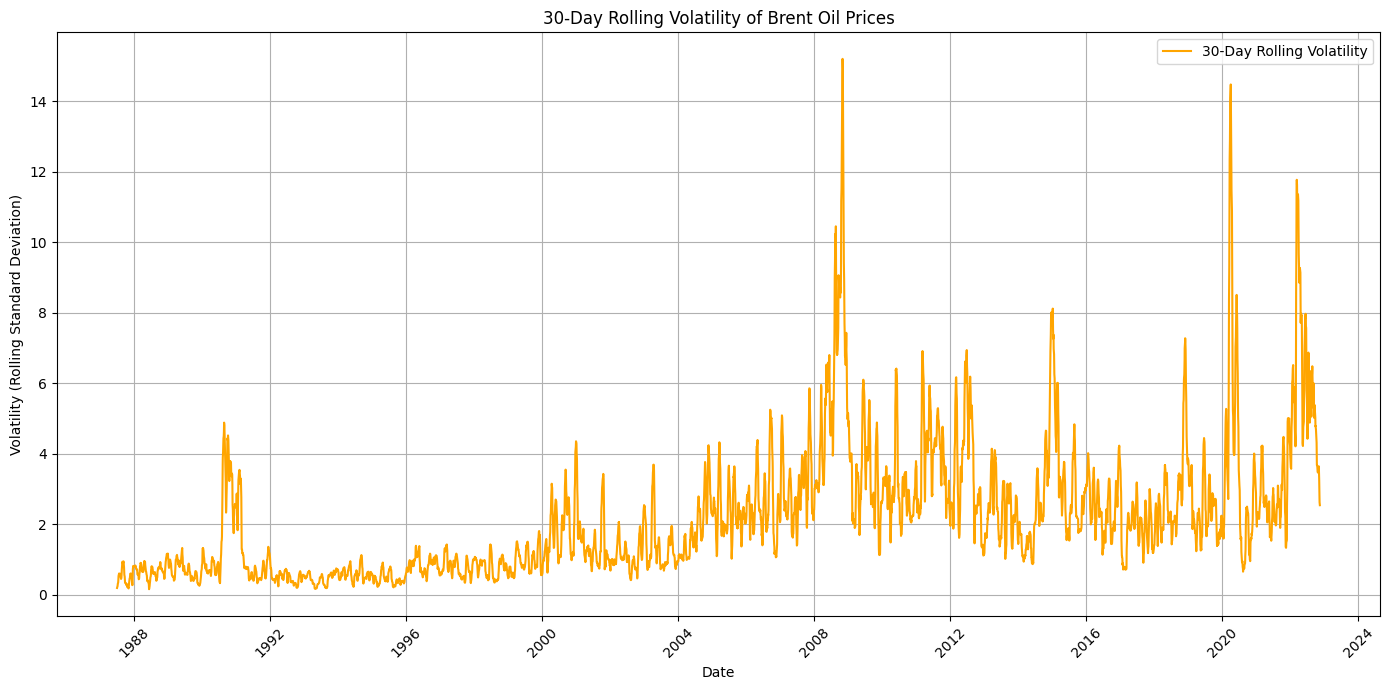

In [78]:
def plot_rolling_volatility(price_data, window=30):
    """
    Plot the rolling standard deviation (volatility) of oil prices over a specified window.
    
    Parameters:
    - price_data (pd.DataFrame): DataFrame with 'Date' and 'Price' columns.
    - window (int): The rolling window size in days (default is 30).
    """
    # Calculate rolling standard deviation (volatility)
    price_data['Rolling_Volatility'] = price_data['Price'].rolling(window=window).std()
    
    # Plot
    plt.plot(price_data.index, price_data['Rolling_Volatility'], label=f'{window}-Day Rolling Volatility', color='orange')
    
    # Label and style the plot
    plt.title(f'{window}-Day Rolling Volatility of Brent Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Volatility (Rolling Standard Deviation)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function
plot_rolling_volatility(price_data)

**Seasonal Decomposition**

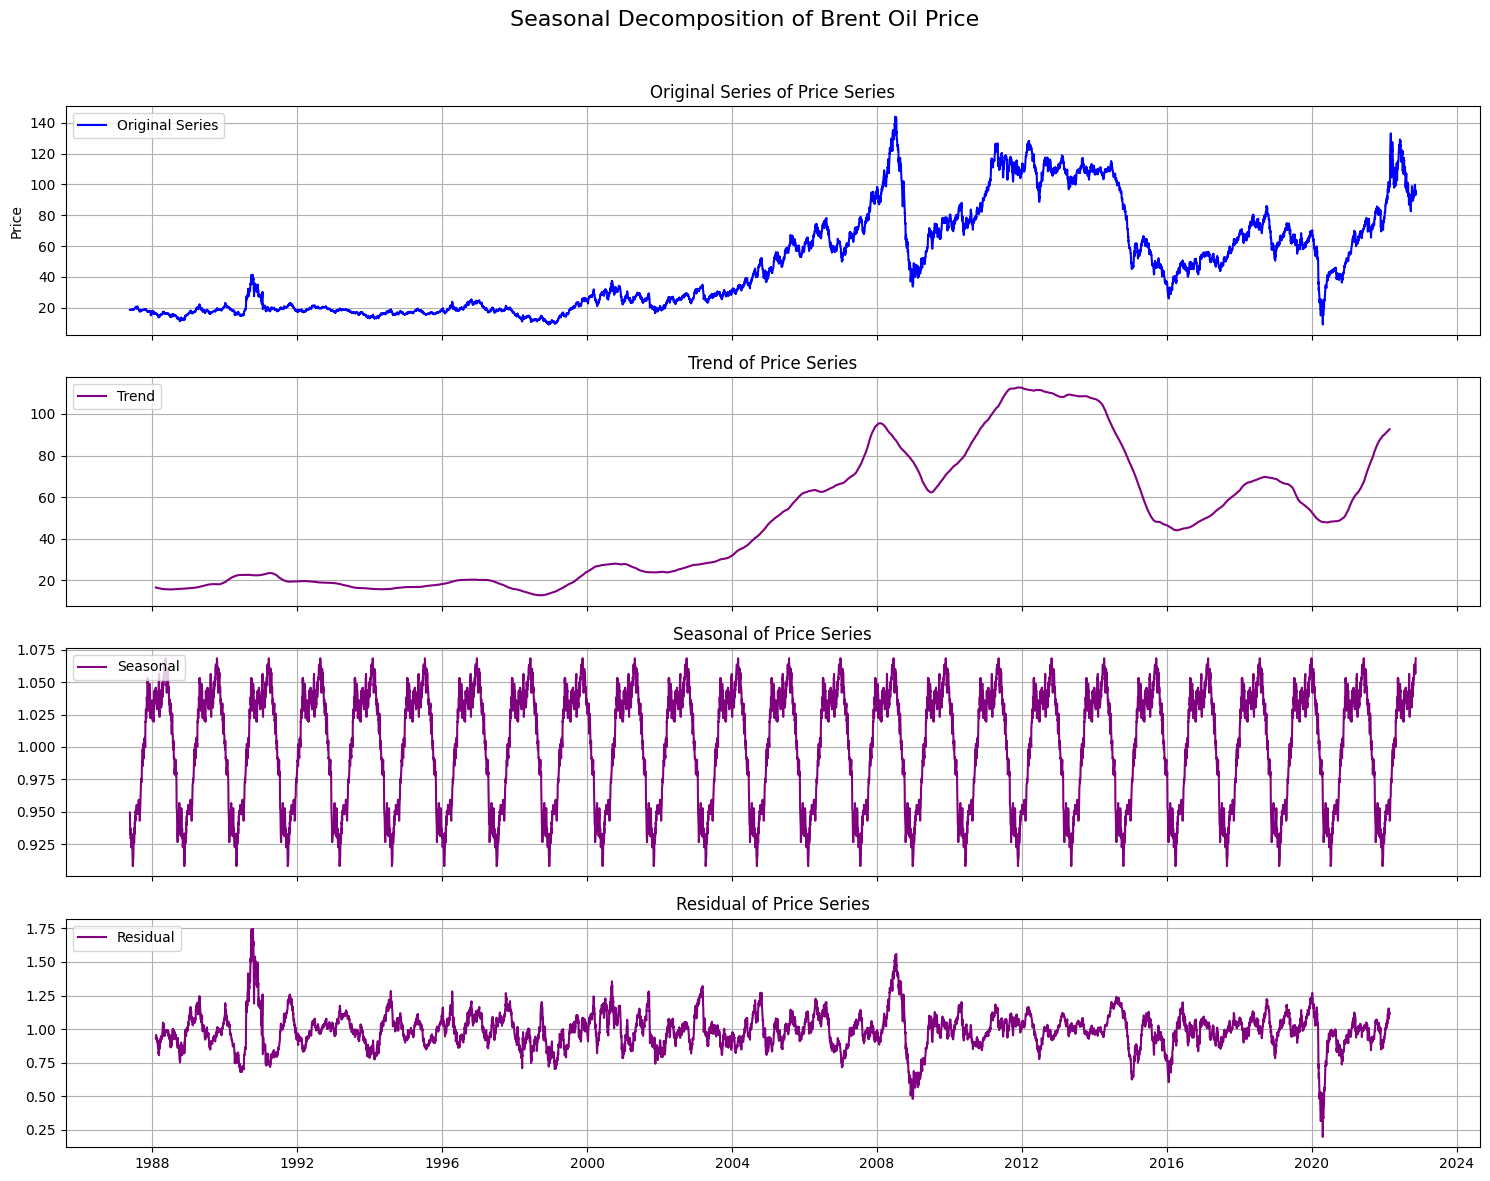

In [79]:
# Apply seasonal decomposition (use model='multiplicative' for data with proportional seasonal effects)
result = seasonal_decompose(price_data['Price'], model='multiplicative', period=365)  # Adjust period if necessary

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
components = ['Original Series', 'Trend', 'Seasonal', 'Residual']
series = [price_data['Price'], result.trend, result.seasonal, result.resid]

for ax, comp, ser in zip(axes, components, series):
    ax.plot(price_data.index, ser, label=comp, color='b' if comp == 'Original Series' else 'purple')
    ax.set_title(f'{comp} of Price Series')
    ax.set_ylabel('Price' if comp == 'Original Series' else '')
    ax.grid(True)
    ax.legend(loc='upper left')

# Improve layout and display the plot
fig.suptitle('Seasonal Decomposition of Brent Oil Price', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()

**Stationaly Analysis of Time Series Data**

- Apply the Augmented Dickey-Fuller (ADF) Test

ADF Statistic: -11.250179655838952
p-value: 1.719784457068474e-20
Critical Values:
   1%: -3.431079878822629
   5%: -2.8618625589084705
   10%: -2.566941693085751
The ADF test suggests the series is stationary.


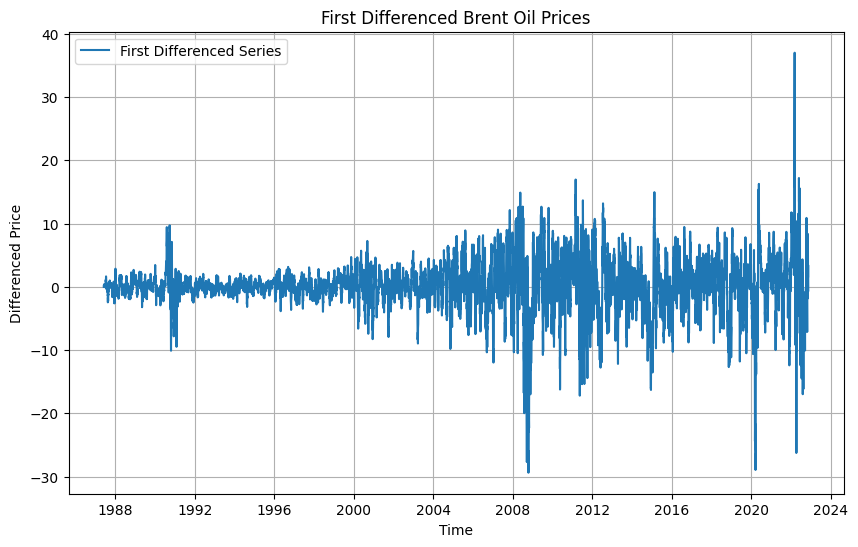

(-11.250179655838952, 1.719784457068474e-20)

In [80]:
def test_stationarity(series, title, label, alpha=0.05):
    adf_result = adfuller(series)
    
    # Print ADF results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')
    
    # Interpretation
    if adf_result[1] < alpha:
        print("The ADF test suggests the series is stationary.")
    else:
        print("The ADF test suggests the series is not stationary.")

    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(series, label=label)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Differenced Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return adf_result[0], adf_result[1]  # Returning ADF statistic and p-value for further use

# Assuming 'price_data' is your DataFrame with a 'Price' column
data = price_data['Price']

# First differencing
data_diff = data.diff(12).dropna()
test_stationarity(data_diff, title='First Differenced Brent Oil Prices', label='First Differenced Series')

ADF Statistic: -16.42711349448597
p-value: 2.498580161142495e-29
Critical Values:
   1%: -3.4310783342658615
   5%: -2.861861876398633
   10%: -2.566941329781918
The ADF test suggests the series is stationary.


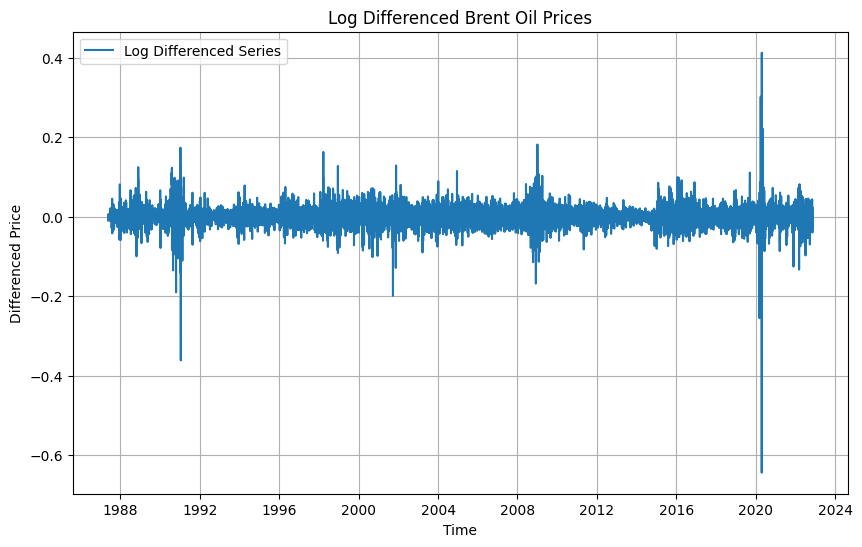

(-16.42711349448597, 2.498580161142495e-29)

In [81]:
# Log transformation
log_data = np.log(price_data['Price'])
log_data_diff = log_data.diff().dropna()
test_stationarity(log_data_diff, title='Log Differenced Brent Oil Prices', label='Log Differenced Series')


### Event Specific Change Analysis

CUSUM Analysis

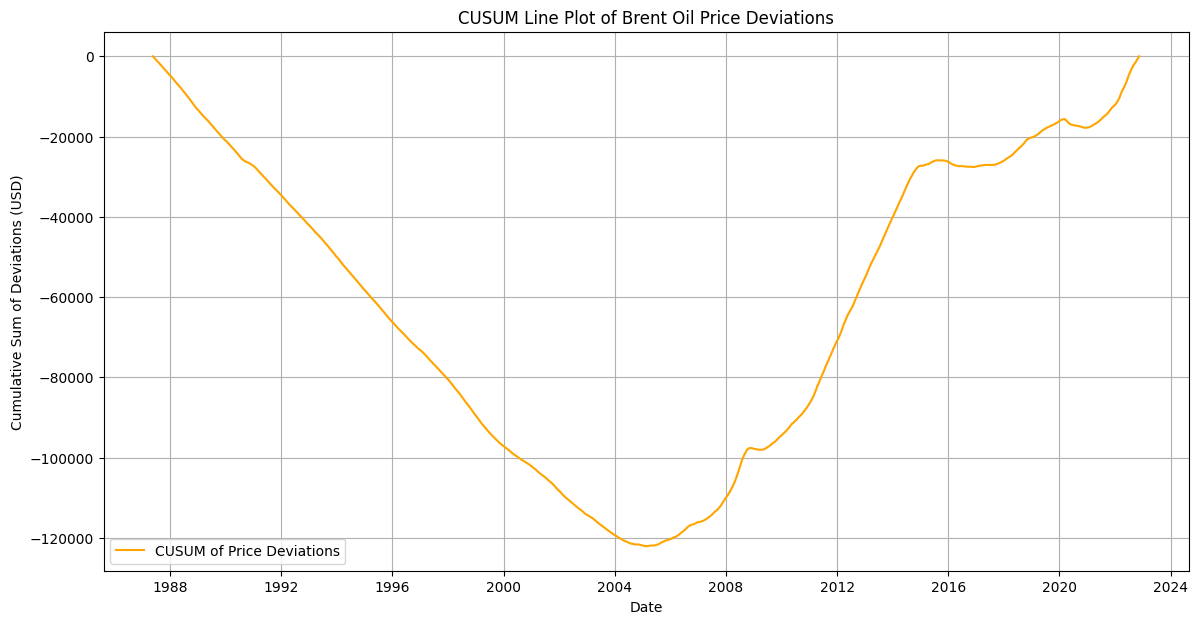

In [82]:
# Calculate CUSUM (Cumulative Sum of Deviations from Mean)
mean_price = price_data['Price'].mean()
cusum = (price_data['Price'] - mean_price).cumsum()

# Plotting the CUSUM line plot
plt.plot(price_data.index, cusum, label='CUSUM of Price Deviations', color='orange')

# Enhancements for better readability
plt.title('CUSUM Line Plot of Brent Oil Price Deviations')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum of Deviations (USD)')
plt.legend()
plt.grid()
plt.show()

**Change Point Analysis with CUSUM**

Detected change point years: [1999, 2005, 2010, 2014, 2021]


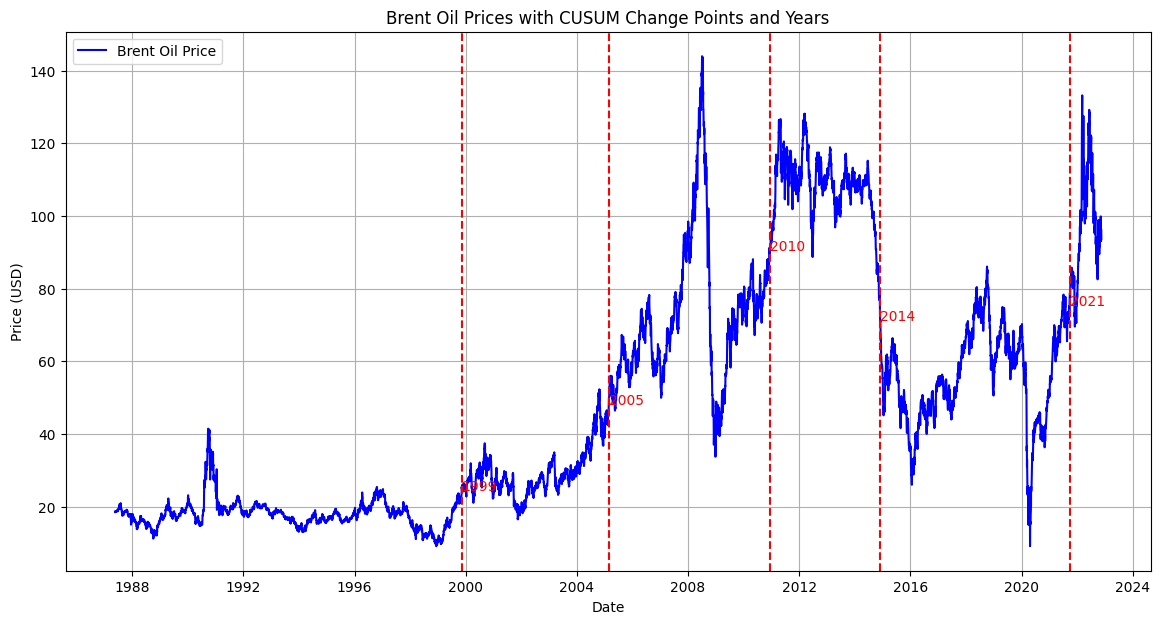

In [83]:
import ruptures as rpt

# Extract the price series for change point detection
price_df = price_data.reset_index()
price_series = price_df['Price'].values

# Apply the CUSUM-based method for change point detection
algo = rpt.Binseg(model="l2").fit(price_series)
change_points = algo.predict(n_bkps=5)  # Adjust n_bkps for more or fewer breakpoints

# Extract and print the year of each change point
change_years = [price_df['Date'].iloc[cp].year for cp in change_points[:-1]]  # Exclude the last index (end of data)
print("Detected change point years:", change_years)

# Plotting the Brent Oil Price with change points
plt.plot(price_df['Date'], price_df['Price'], label='Brent Oil Price', color='blue')

# Overlay detected change points with year annotations
for cp in change_points[:-1]:  # Exclude the last point (end of data)
    year = price_df['Date'].iloc[cp].year
    plt.axvline(price_df['Date'].iloc[cp], color='red', linestyle='--')
    plt.text(price_df['Date'].iloc[cp], price_data['Price'].iloc[cp], str(year), color="red", fontsize=10)

# Enhancements
plt.title('Brent Oil Prices with CUSUM Change Points and Years')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

Baysian Change Point Detection

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


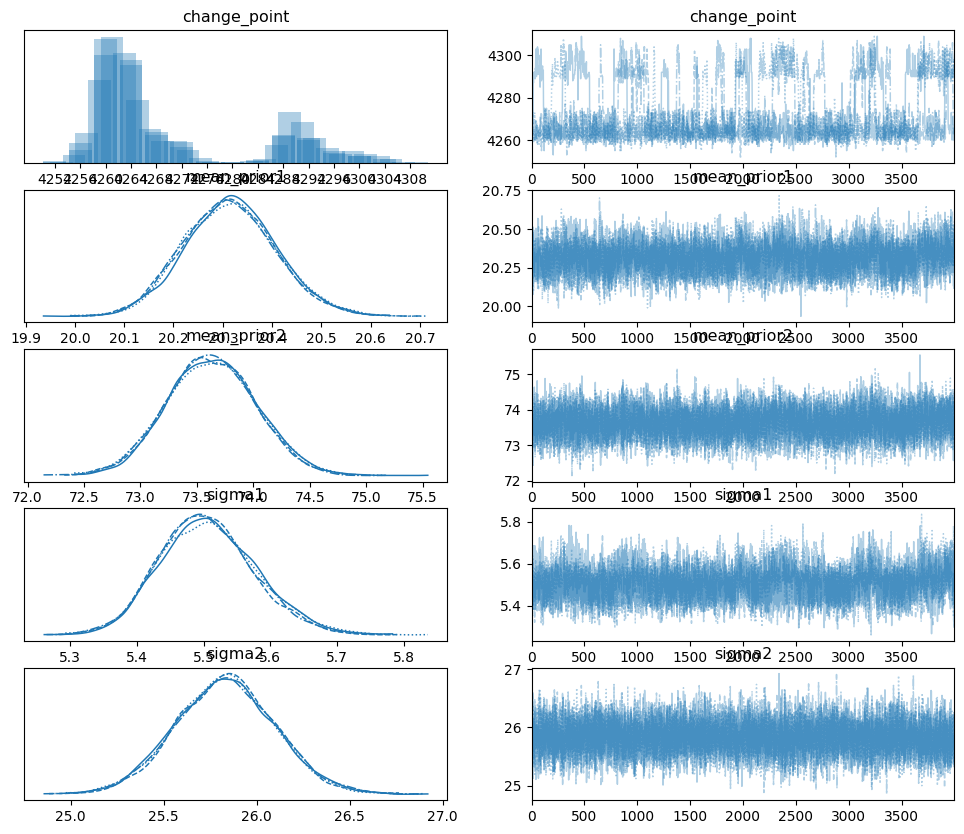

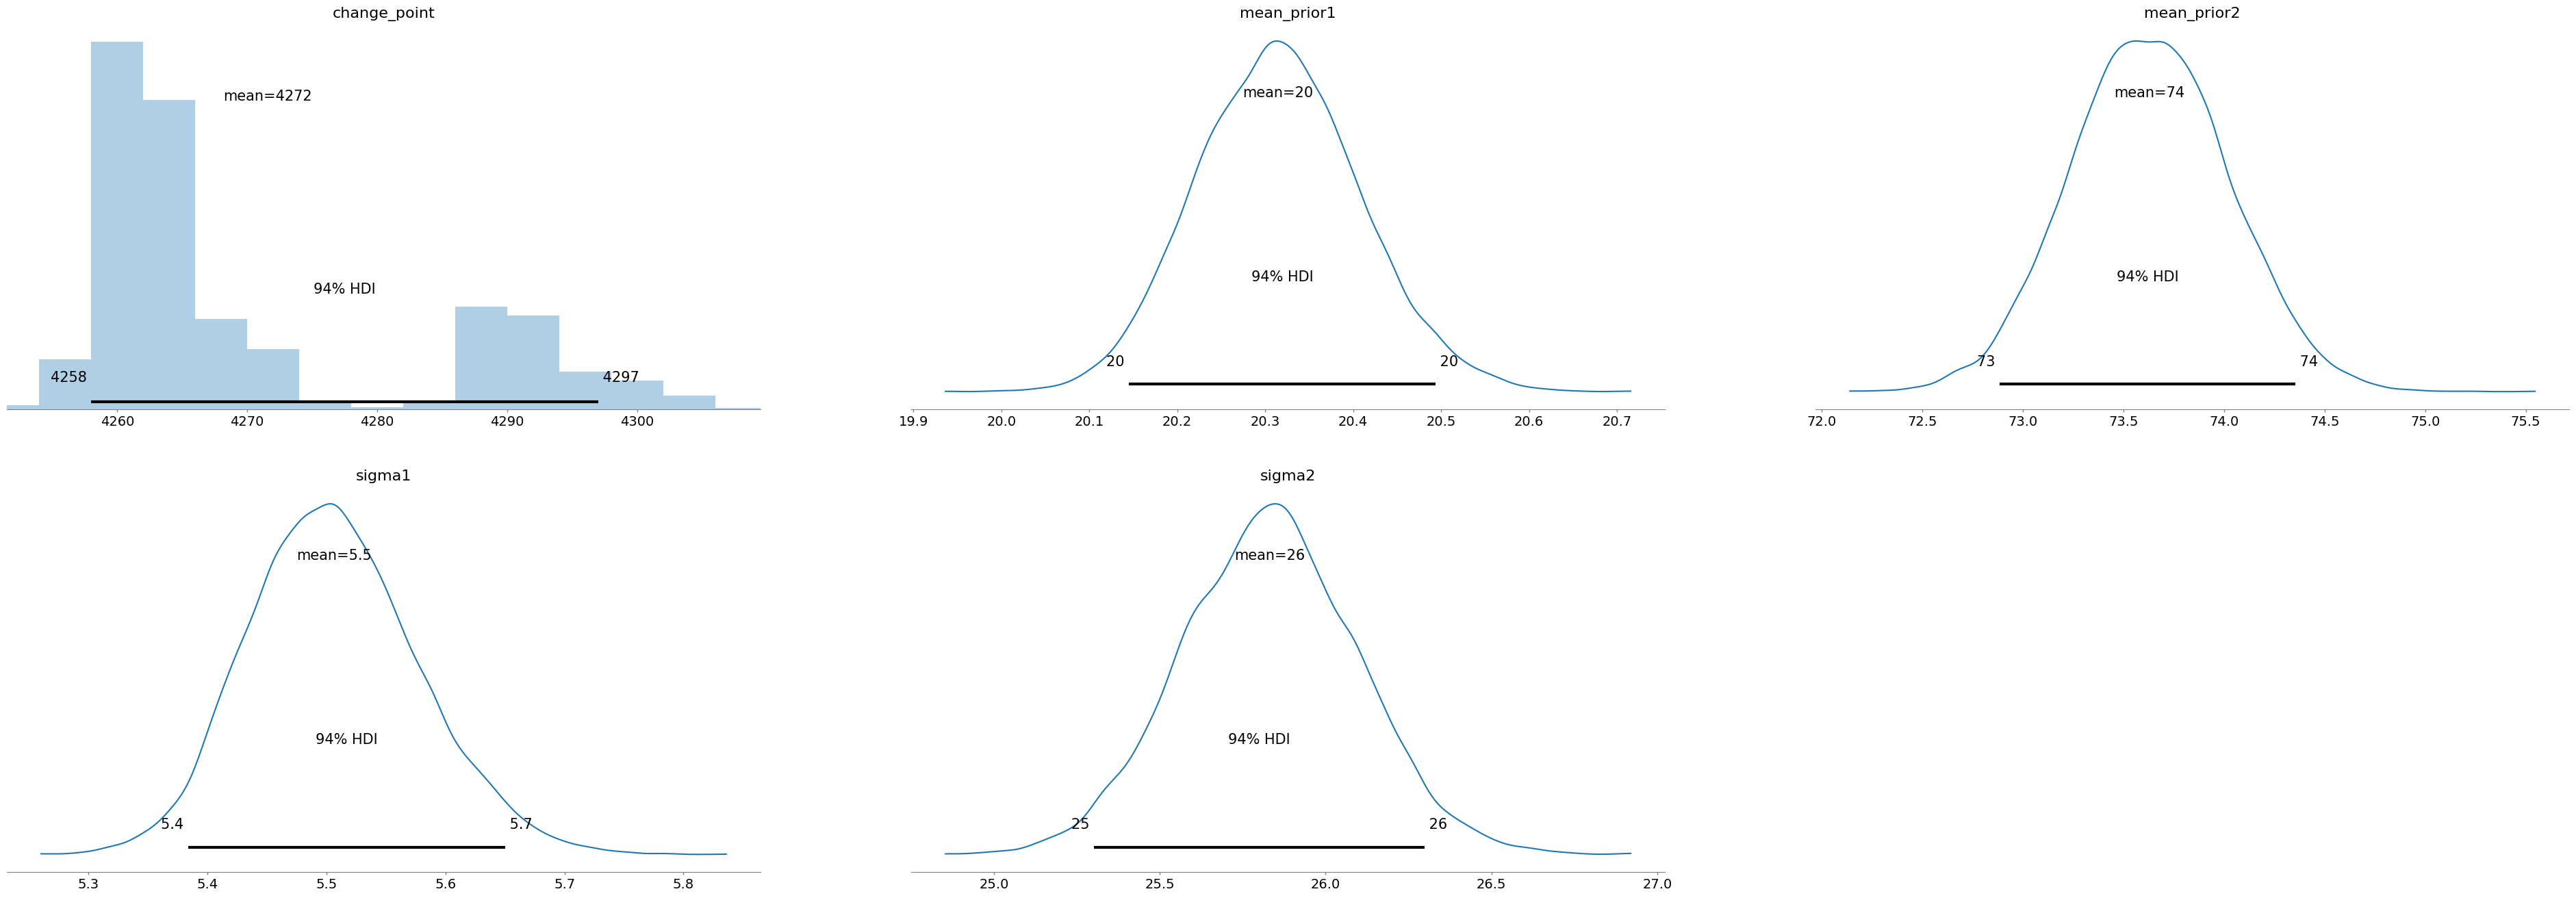

Estimated Change Point Date: 2004-03-02 00:00:00
95% HDI for the Change Point: [4257 4298]


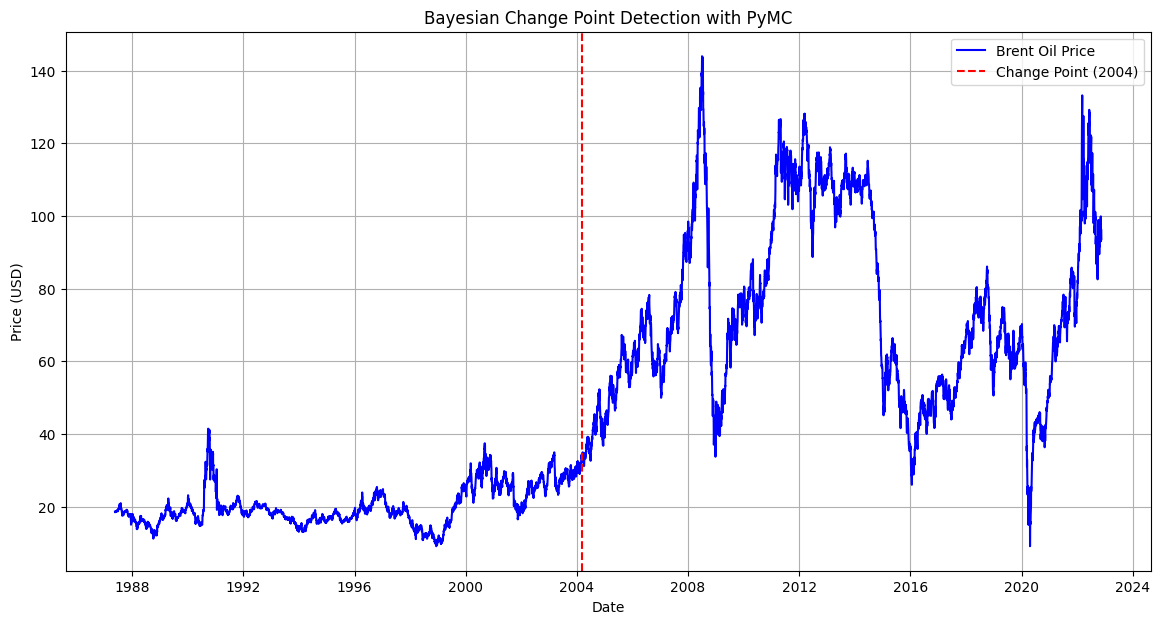

In [84]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

# Load your price data (Assuming 'price_data' is a DataFrame with 'Date' as index and 'Price' as column)

# Extract price values for modeling
data = price_data['Price'].values

# Set informative mean priors based on analysis of data
prior_mu1 = np.mean(data)  # Prior mean for the first segment
prior_mu2 = np.mean(data)  # Prior mean for the second segment

with pm.Model() as model:
    # Define the change point
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(data) - 1)

    # Segment-specific means and standard deviations
    mu1 = pm.Normal('mean_prior1', mu=prior_mu1, sigma=5)  # Mean for segment 1
    mu2 = pm.Normal('mean_prior2', mu=prior_mu2, sigma=5)  # Mean for segment 2
    sigma1 = pm.HalfNormal('sigma1', sigma=5)  # Std deviation for segment 1
    sigma2 = pm.HalfNormal('sigma2', sigma=5)  # Std deviation for segment 2

    # Likelihood with switching behavior at change point
    likelihood = pm.Normal('likelihood',
                           mu=pm.math.switch(change_point >= np.arange(len(data)), mu1, mu2),
                           sigma=pm.math.switch(change_point >= np.arange(len(data)), sigma1, sigma2),
                           observed=data)

    # Sample from the posterior
    trace = pm.sample(4000, tune=2000, chains=4, random_seed=42)
    
# Plot convergence diagnostics
az.plot_trace(trace)

# Plot posterior distributions
pm.plot_posterior(trace)
plt.show()

# Analyze the change point
s_posterior = trace.posterior['change_point'].values.flatten()
estimated_change_point = int(np.median(s_posterior))

# Map change point index back to date
change_point_date = price_data.index[estimated_change_point]
print(f"Estimated Change Point Date: {change_point_date}")

# Calculate 95% HDI for the change point
hdi = az.hdi(s_posterior, hdi_prob=0.95)
print(f"95% HDI for the Change Point: {hdi}")

# Visualize the change point on the price data
plt.plot(price_data.index, data, label='Brent Oil Price', color='blue')
plt.axvline(change_point_date, color='red', linestyle='--', label=f'Change Point ({change_point_date.year})')
plt.title('Bayesian Change Point Detection with PyMC')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


- **Box Plot of Price Distributions by Segment**

    - Box plots can be created for each segment between change points, giving insights into the distribution characteristics within each period, both before and after each shift.

/tmp/ipykernel_37226/4157517537.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y='Price', data=price_data.reset_index(), palette="Set3")


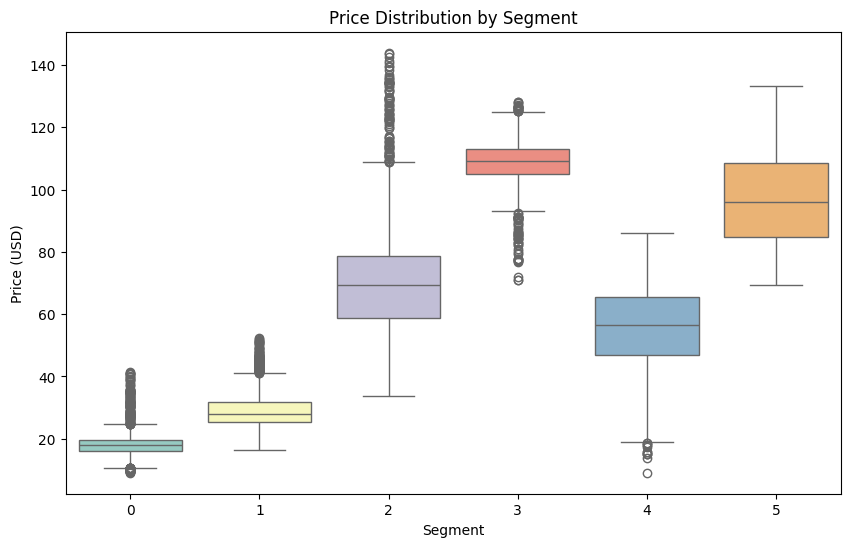

In [85]:
# Box Plot of Price Distributions by Segment
# Convert change_points from indexes to dates
change_point_dates = price_data.index[change_points[:-1]]

# Create a 'Segment' column based on change points
price_data['Segment'] = 0
for i, cp in enumerate(change_point_dates):
    price_data.loc[price_data.index > cp, 'Segment'] = i + 1

plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Price', data=price_data.reset_index(), palette="Set3")
plt.title('Price Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Price (USD)')
plt.show()

### Event Impact Analysis

Based on the previous analysis on detecting the change points the following key events are identified that were impacted oil prices

1999
Russian Financial Crisis: The Russian default on its debt and devaluation of the ruble in 1998 led to a sharp drop in oil prices, but by 1999, the recovery began as oil demand increased, particularly from Asia.

2005
Hurricane Katrina: This devastating hurricane struck the Gulf Coast of the United States in August 2005, causing significant disruptions to oil production and refining capacity, leading to a spike in oil prices.

2010
Arab Spring: The wave of protests and uprisings across the Arab world began in late 2010, leading to political instability in key oil-producing countries such as Libya and Egypt, which drove up Brent oil prices.

2014
Oil Price Crash: In mid-2014, Brent oil prices began to decline sharply due to oversupply in the market, driven by increased production from the U.S. shale oil boom and OPEC's decision not to cut output.

2021
COVID-19 Pandemic Recovery: As global economies began to reopen following lockdowns, demand for oil surged, contributing to significant price increases in 2021. Additionally, OPEC+ production cuts played a role in driving prices higher.

In [86]:
# Assuming 'change_years' is a list of date strings for change points
change_dates = pd.to_datetime(change_years)  # Converting change dates to datetime if not already

# The researched key events associated with change points
key_events = {
    "Russian Financial Crisis": "1999-08-17",
    "Hurricane Katrina": "2005-08-29",
    "Arab Spring": "2010-12-14",
    "U.S. shale oil boom": "2014-06-30",
    "Post-COVID-19 Recovery + OPEC+ Cuts": "2021-09-22",
}



**Price Change Analysis**

Percentage Change Calculation:
-  Measure the percentage change in oil prices before and after each key event. This can be calculated as:
Percentage Change
=
(
Price After
−
Price Before
Price Before
)
×
100
Percentage Change=( 
Price Before
Price After−Price Before
​
 )×100
 
2. Cumulative Returns
Calculate cumulative returns over a specified period before and after the event. This can provide insight into the overall impact of the event on price movements.

                                 Event        Date  Change_1M  Change_3M  \
0             Russian Financial Crisis  1999-08-17        NaN  79.819695   
1                    Hurricane Katrina  2005-08-29        NaN        NaN   
2                          Arab Spring  2010-12-14        NaN  43.958705   
3                  U.S. shale oil boom  2014-06-30        NaN        NaN   
4  Post-COVID-19 Recovery + OPEC+ Cuts  2021-09-22  23.686116  -4.081633   

   Change_6M  Cumulative Return Before  Cumulative Return After  
0        NaN                  1.075529                 0.349830  
1        NaN                  0.268756                -0.071638  
2        NaN                  0.169118                 0.309831  
3        NaN                  0.028627                -0.471134  
4  91.767289                  0.183942                 0.619735  


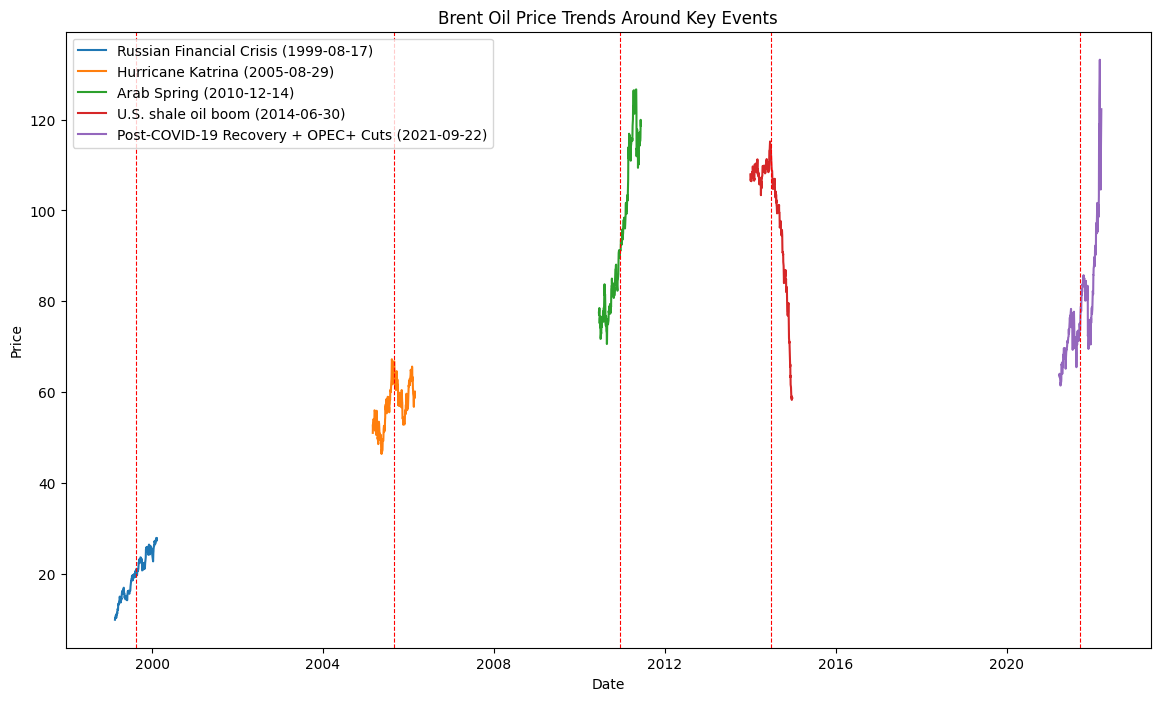

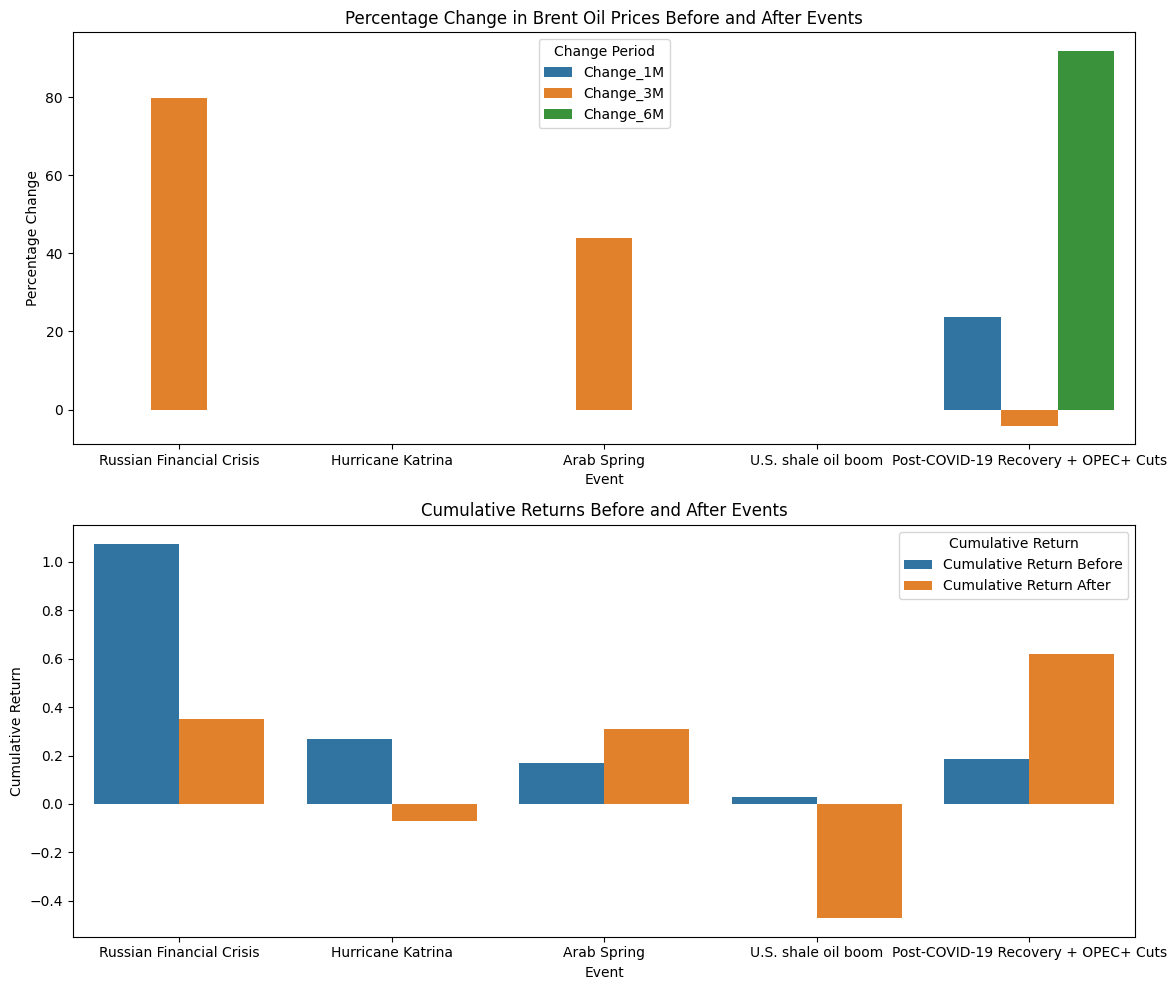

                                     t-statistic       p-value
Russian Financial Crisis              -13.621948  5.968134e-32
Hurricane Katrina                     -13.621948  5.968134e-32
Arab Spring                           -13.621948  5.968134e-32
U.S. shale oil boom                   -13.621948  5.968134e-32
Post-COVID-19 Recovery + OPEC+ Cuts   -13.621948  5.968134e-32


In [87]:
from datetime import timedelta
from scipy import stats


# Function to get prices around an event
def get_prices_around_event(event_date, price_data, days_before=30, days_after=30):
    before_date = event_date - timedelta(days=days_before)
    after_date = event_date + timedelta(days=days_after)
    prices_around_event = price_data[(price_data.index >= before_date) & (price_data.index <= after_date)]
    return prices_around_event

# Calculate percentage changes and cumulative returns
results = []
for event, date in key_events.items():
    event_date = pd.to_datetime(date)
    prices_around_event = get_prices_around_event(event_date, price_data, days_before=180, days_after=180)
    
    # Calculate percentage changes at different intervals
    try:
        price_before_1m = price_data.loc[event_date - timedelta(days=30), 'Price']
        price_after_1m = price_data.loc[event_date + timedelta(days=30), 'Price']
        change_1m = ((price_after_1m - price_before_1m) / price_before_1m) * 100
    except KeyError:
        change_1m = None
    
    try:
        price_before_3m = price_data.loc[event_date - timedelta(days=90), 'Price']
        price_after_3m = price_data.loc[event_date + timedelta(days=90), 'Price']
        change_3m = ((price_after_3m - price_before_3m) / price_before_3m) * 100
    except KeyError:
        change_3m = None

    try:
        price_before_6m = price_data.loc[event_date - timedelta(days=180), 'Price']
        price_after_6m = price_data.loc[event_date + timedelta(days=180), 'Price']
        change_6m = ((price_after_6m - price_before_6m) / price_before_6m) * 100
    except KeyError:
        change_6m = None
    
    # Calculate cumulative returns around the event
    cum_return_before = prices_around_event.loc[:event_date].pct_change().add(1).cumprod().iloc[-1] - 1
    cum_return_after = prices_around_event.loc[event_date:].pct_change().add(1).cumprod().iloc[-1] - 1
    
    results.append({
        "Event": event,
        "Date": date,
        "Change_1M": change_1m,
        "Change_3M": change_3m,
        "Change_6M": change_6m,
        "Cumulative Return Before": cum_return_before['Price'],
        "Cumulative Return After": cum_return_after['Price']
    })

# Create a DataFrame for easier analysis
event_impact_df = pd.DataFrame(results)
print(event_impact_df)

# Visualization of Price Trends Around Events
plt.figure(figsize=(14, 8))
for event, date in key_events.items():
    event_date = pd.to_datetime(date)
    prices_around_event = get_prices_around_event(event_date, price_data, days_before=180, days_after=180)
    
    plt.plot(prices_around_event.index, prices_around_event['Price'], label=f"{event} ({date})")
    plt.axvline(event_date, color='red', linestyle='--', linewidth=0.8)

plt.title("Brent Oil Price Trends Around Key Events")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot Percentage Changes and Cumulative Returns
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Bar plot for percentage changes
sns.barplot(data=event_impact_df.melt(id_vars=["Event", "Date"], 
                                      value_vars=["Change_1M", "Change_3M", "Change_6M"]),
            x="Event", y="value", hue="variable", ax=axes[0])
axes[0].set_title("Percentage Change in Brent Oil Prices Before and After Events")
axes[0].set_ylabel("Percentage Change")
axes[0].legend(title="Change Period")

# Bar plot for cumulative returns
sns.barplot(data=event_impact_df.melt(id_vars=["Event", "Date"], 
                                      value_vars=["Cumulative Return Before", "Cumulative Return After"]),
            x="Event", y="value", hue="variable", ax=axes[1])
axes[1].set_title("Cumulative Returns Before and After Events")
axes[1].set_ylabel("Cumulative Return")
axes[1].legend(title="Cumulative Return")

plt.tight_layout()
plt.show()

# Optional Statistical Analysis (t-test for significant price changes)
t_test_results = {}
for event in key_events.keys():
    before_prices = get_prices_around_event(event_date, price_data, days_before=180).loc[:event_date]['Price']
    after_prices = get_prices_around_event(event_date, price_data, days_after=180).loc[event_date:]['Price']
    t_stat, p_val = stats.ttest_ind(before_prices, after_prices, nan_policy='omit')
    t_test_results[event] = {"t-statistic": t_stat, "p-value": p_val}

# Display t-test results
t_test_df = pd.DataFrame(t_test_results).T
print(t_test_df)


## Model Implementation

### Download Economic Indicators Dataset from World bank

In [88]:
# Install wbdata
#%pip install wbdata

In [110]:
import wbdata

def fetch_data(indicator_code, indicator_name, country='WLD', start_date=None, end_date=None):
    """Fetches data from World Bank Data for a specified indicator."""
    data = wbdata.get_dataframe({indicator_code: indicator_name}, country=country, date=(start_date, end_date))
    return data

def clean_data(df):
    """Cleans the DataFrame by resetting index, renaming columns, and handling missing values."""
    if df is not None and not df.empty:
        df.reset_index(inplace=True)
        df.columns = ['date', df.columns[1]]  # Keep the first column as 'date', second as the indicator name
        df.dropna(inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        return df
    return pd.DataFrame()  # Return an empty DataFrame if input is None or empty

def convert_to_daily(df):
    """Converts a DataFrame with dates to a daily frequency."""
    full_index = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    df_daily = df.set_index('date').reindex(full_index)
    df_daily.interpolate(method='time', inplace=True)  # Interpolate to fill missing values
    df_daily.reset_index(inplace=True)
    df_daily.rename(columns={'index': 'Date'}, inplace=True)
    return df_daily

# Set the indicator codes
gdp_indicator = 'NY.GDP.MKTP.CD'                # GDP (current US$)
cpi_indicator = 'FP.CPI.TOTL.ZG'                    # Inflation (CPI)
unemployment_indicator = 'SL.UEM.TOTL.ZS'        # Unemployment rate (% of total labor force)
exchange_rate_indicator = 'PA.NUS.FCRF'         # Exchange rate, USD to other currencies

# Define the date range
start_date = '1987-05-20'
end_date = '2022-11-14'

# Fetch and clean data for each indicator
gdp_data = clean_data(fetch_data(gdp_indicator, 'GDP', country='WLD', start_date=start_date, end_date=end_date))
cpi_data = clean_data(fetch_data(cpi_indicator, 'CPI', country='WLD', start_date=start_date, end_date=end_date))
unemployment_data = clean_data(fetch_data(unemployment_indicator, 'Unemployment Rate', country='WLD', start_date=start_date, end_date=end_date))
exchange_rate_data = clean_data(fetch_data(exchange_rate_indicator, 'Exchange Rate', country='USA', start_date=start_date, end_date=end_date))

# Convert to daily frequency
gdp_data_daily = convert_to_daily(gdp_data)
cpi_data_daily = convert_to_daily(cpi_data)
unemployment_data_daily = convert_to_daily(unemployment_data)
exchange_rate_data_daily = convert_to_daily(exchange_rate_data)

# Save each cleaned DataFrame to a CSV file
gdp_data_daily.to_csv("../data/GDP_cleaned_data_daily.csv", index=False)
cpi_data_daily.to_csv("../data/CPI_cleaned_data_daily.csv", index=False)
unemployment_data_daily.to_csv("../data/Unemployment_Rate_cleaned_data_daily.csv", index=False)
exchange_rate_data_daily.to_csv("../data/Exchange_Rate_cleaned_data_daily.csv", index=False)




Investigate relationships between econometric indicators and oil prices


Correlation between GDP and oil prices: 0.7560831605553207


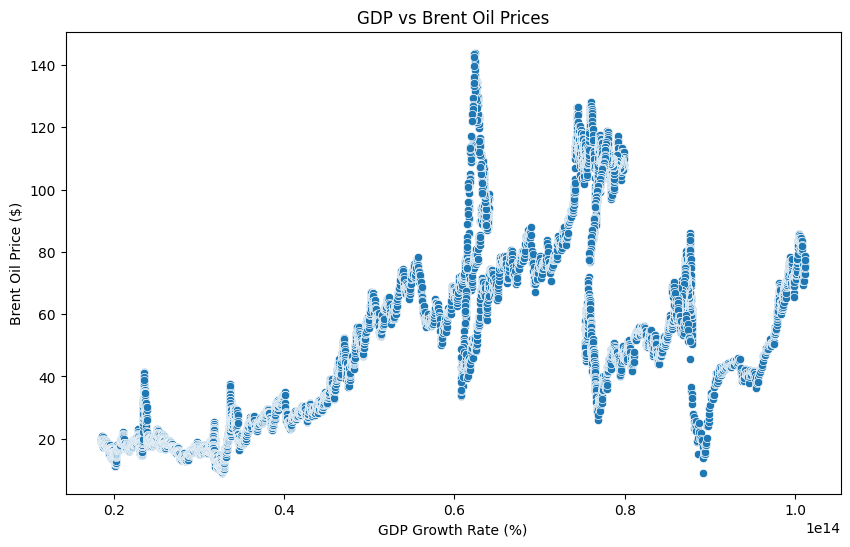

Correlation between CPI and oil prices: -0.4082153436909551


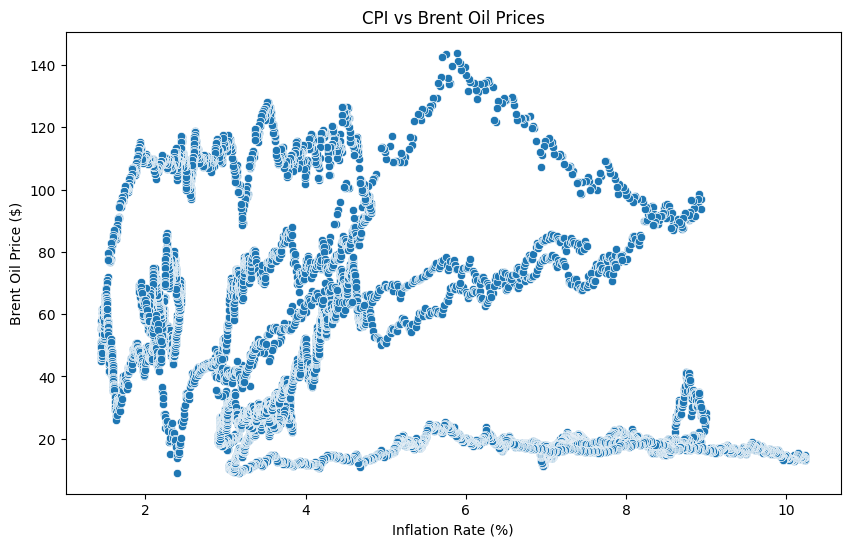

Correlation between Unemployment Rate and oil prices: 0.17293234258935586


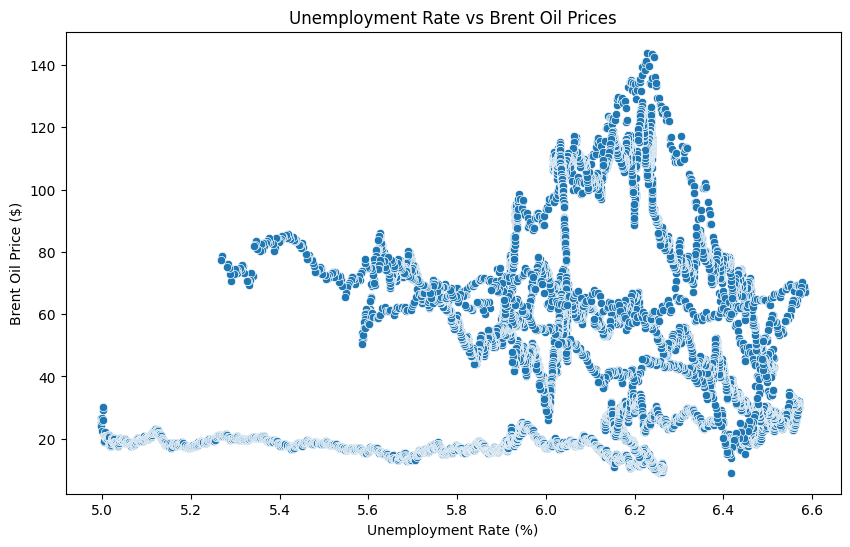

/home/noh/10Academy/oil-price-statistical-modeling/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/noh/10Academy/oil-price-statistical-modeling/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between Exchange Rate and oil prices: nan


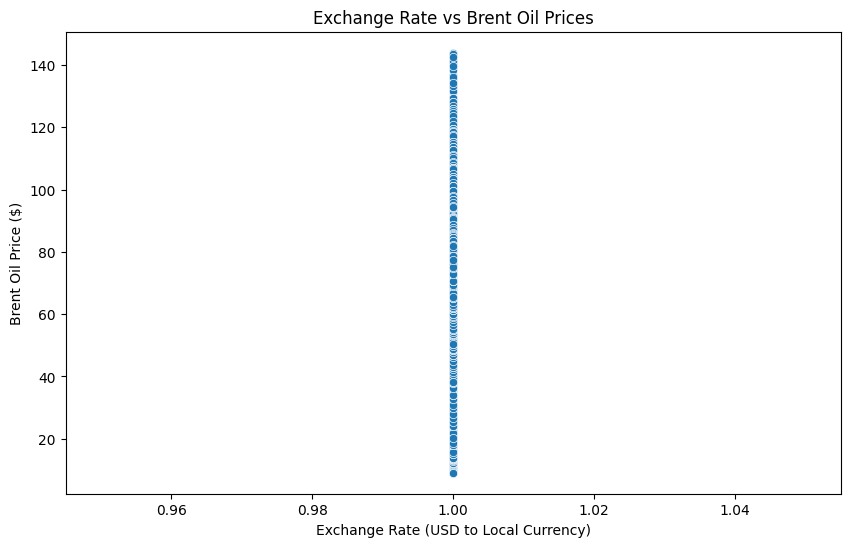

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_indicators(gdp_data, inflation_data, unemployment_data, exchange_rate_data, oil_data):
    """
    Analyzes the correlation between economic indicators and oil prices,
    and generates scatter plots for each indicator.
    
    Parameters:
    gdp_data (DataFrame): Daily GDP data with columns ['Date', 'GDP'].
    inflation_data (DataFrame): Daily inflation data with columns ['Date', 'CPI'].
    unemployment_data (DataFrame): Daily unemployment data with columns ['Date', 'Unemployment Rate'].
    exchange_rate_data (DataFrame): Daily exchange rate data with columns ['Date', 'Exchange Rate'].
    oil_data (DataFrame): Daily oil price data with columns ['Date', 'Price'].
    """
    
    # Function to merge and analyze
    def analyze_and_plot(indicator_data, indicator_name, oil_data, x_label):
        merged_data = pd.merge(indicator_data, oil_data.reset_index(), on='Date')
        
        # Drop NaN values to ensure correlation calculation is valid
        merged_data.dropna(inplace=True)
        
        correlation = merged_data[indicator_name].corr(merged_data['Price'])
        print(f"Correlation between {indicator_name} and oil prices: {correlation}")

        # Scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=merged_data, x=indicator_name, y='Price')
        plt.title(f'{indicator_name} vs Brent Oil Prices')
        plt.xlabel(x_label)
        plt.ylabel('Brent Oil Price ($)')
        plt.show()

    # Analyze GDP
    analyze_and_plot(gdp_data, 'GDP', oil_data, 'GDP Growth Rate (%)')

    # Analyze Inflation
    analyze_and_plot(inflation_data, 'CPI', oil_data, 'Inflation Rate (%)')

    # Analyze Unemployment
    analyze_and_plot(unemployment_data, 'Unemployment Rate', oil_data, 'Unemployment Rate (%)')

    # Analyze Exchange Rate
    analyze_and_plot(exchange_rate_data, 'Exchange Rate', oil_data, 'Exchange Rate (USD to Local Currency)')

# Example of calling the function
# Ensure you have the cleaned daily data for each indicator ready
# gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, and price_data_daily
analyze_indicators(gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, price_data)


I chose the following models based on the results of previous analysis

1. **ARIMA**:Since the timme series is stationary

2. **GARCH:**

    - Given the unpredictable variations highlighted in the residuals (potentially driven by geopolitical or economic events), it might also be worthwhile to consider a GARCH model to capture and model the changing volatility over time.

**Step 1: Determine ARIMA Parameters (p, d, q):**
- use autocorrelation and partial autocorrelation plots (ACF and PACF) to determine suitable values for p and q.

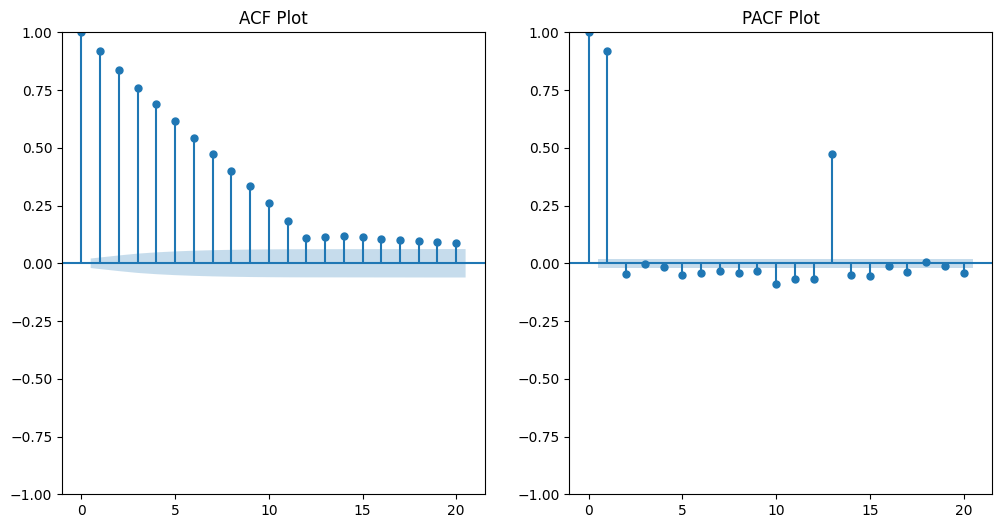

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data_diff, lags=20, ax=plt.gca())
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(data_diff, lags=20, ax=plt.gca())
plt.title('PACF Plot')
plt.show()


**Step 2: Fit the ARIMA Model:** Fit the ARIMA model with the determined parameters.

In [ ]:
# Ensure your index is datetime and has daily frequency
data = price_data.copy()
data.index = pd.date_range(start=data.index[0], periods=len(price_data), freq='D')

# Define the model
p = 1  # AR order
d = 1  # differencing
q = 1  # MA order
model = ARIMA(data['Price'], order=(p, d, q))

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())



                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Mon, 04 Nov 2024   AIC                          29093.899
Time:                        05:05:43   BIC                          29115.218
Sample:                    05-20-1987   HQIC                         29101.153
                         - 01-19-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

**Insights:**

- Model Fit: The model appears to fit the data reasonably well, as indicated by the statistical tests, especially the Ljung-Box test showing no significant autocorrelation in residuals.

- Normality and Heteroskedasticity: The residuals' non-normality and the presence of heteroskedasticity suggest you may need to further investigate the model or consider transformations or different modeling strategies.

- Model Selection: Consider fitting alternative models (like GARCH models for handling volatility) to see if they yield better performance based on the AIC/BIC or other criteria.

**Step 3: Use GARCH**
- First, install arc(pip install arc)

In [ ]:
# Calculate Log Returns
price_data['Log_Ret'] = np.log(price_data['Price']).diff().dropna()
log_returns = price_data['Log_Ret'].dropna()

In [ ]:
from arch import arch_model

# Fit a GARCH(1,1) model
garch_model = arch_model(log_returns, vol='Garch', p=1, q=1, rescale=False)
garch_model_fit = garch_model.fit(disp='off')  # Set disp to 'off' to avoid printing output

# Print the summary of the model
print(garch_model_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Log_Ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                22187.5
Distribution:                  Normal   AIC:                          -44367.1
Method:            Maximum Likelihood   BIC:                          -44338.7
                                        No. Observations:                 9010
Date:                Mon, Nov 04 2024   Df Residuals:                     9009
Time:                        05:05:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.0513e-04  1.903e-04      2.654  7.961e-03 [1.

**Key Insights**

- Volatility Dynamics: The significant values of both alpha and beta indicate that the GARCH(1,1) model is capturing the volatility clustering often observed in financial time series data. This means that periods of high volatility are likely to be followed by more periods of high volatility, and similarly for low volatility.

- Model Fit: The model's log-likelihood, AIC, and BIC suggest a good fit for the GARCH model, but further comparisons with other models might be needed to confirm the best specification.

- Mean Return: The positive mean return indicates a slight upward trend in returns, though the overall impact on trading strategies might be minimal given the low magnitude.



**Step 4: Forecasting Volatility**

- use the fitted GARCH model to forecast future volatility.

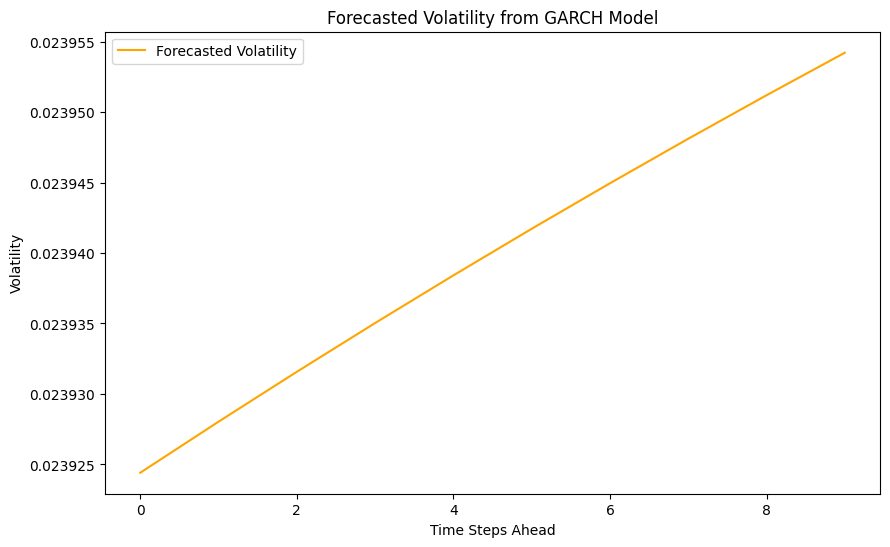

In [ ]:
# Assuming 'garch_model' is your fitted GARCH model
n_forecast = 10  # Number of periods to forecast
forecast = garch_model_fit.forecast(horizon=n_forecast)

# Forecasted volatility
forecasted_volatility = forecast.variance.iloc[-1].values  # Get forecasted variances
forecasted_volatility_sqrt = np.sqrt(forecasted_volatility)  # Convert variance to standard deviation (volatility)

# Plotting the forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(forecasted_volatility_sqrt, label='Forecasted Volatility', color='orange')
plt.title('Forecasted Volatility from GARCH Model')
plt.xlabel('Time Steps Ahead')
plt.ylabel('Volatility')
plt.legend()
plt.show()


**Interpretation:**

- Constant Volatility: A linear trend in the volatility line might indicate that volatility is relatively stable over the observed period. This could imply that market conditions have not changed drastically, leading to a consistent level of price fluctuations.

- Predictability: If the volatility is linear and does not exhibit substantial fluctuations, it could be easier to predict future volatility based on historical patterns. This might simplify risk management strategies, as you may not need to account for significant changes in volatility over time.

- Absence of Major Shocks: A linear trend may reflect the absence of major market shocks or events that typically increase volatility, such as financial crises, geopolitical tensions, or other external factors. It suggests a period of relative calm in the market.

**Step 5: Residual Analysis**



In [ ]:
# Extracting standardized residuals
residuals = garch_model_fit.resid
standardized_residuals = residuals / np.sqrt(garch_model_fit.conditional_volatility)


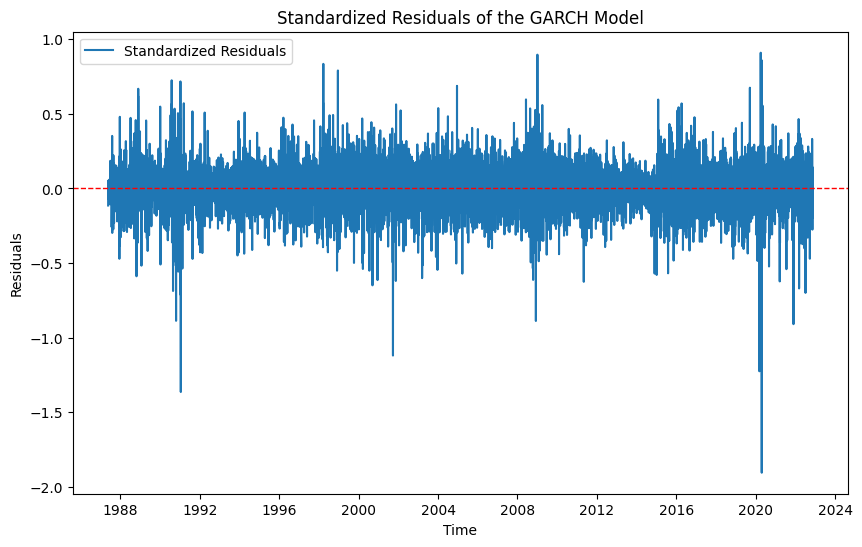

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(standardized_residuals, label='Standardized Residuals')
plt.title('Standardized Residuals of the GARCH Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()


**Summary of Observations:**

- Randomness: The residuals being randomly scattered around zero indicates that the GARCH model has effectively captured the underlying volatility dynamics.

- No Significant Patterns: The absence of trends or cycles in the residuals suggests that the model is neither systematically overestimating nor underestimating volatility, which is a positive sign.

- Outliers: The presence of a few outliers may indicate that while the model performs well overall, it could struggle during extreme market events or due to anomalies in the data.